In [34]:
#import python modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py as h5
import os
import sys
import scipy as sp
import pickle
import seaborn as sns 
# sns.set()
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif',size=14)

In [47]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

In [36]:
#constants and specifics for the models
Tz = 253.15
bdot = 0.3 #W.E.
GRAVITY = 9.8
R = 8.314
rho = 400
RHO_I = 917.0

In [37]:
#function to create steady-state HL depth-density profile.
def hl_analytic(rhos0, h, THL, AHL):
    '''
    Model steady-state firn density and age profiles and bubble close-off, uses m w.e. a^-1

    :param rhos0: surface density
    :param h: depth
    :param THL: 
    :param AHL:

    :return age: age vector of firn column with steady-state dynamics
    :return rho: density vector of firn column with steady state dynamics
    '''
    RHO_1_MGM   = 0.550
    RHO_I_MGM   = 0.917
    R = 8.314
    S_PER_YEAR = 31557600.0

    hSize = np.size(h)
    rhos = rhos0 / 1000.0

    A = AHL * RHO_I_MGM
    k0 = 11.0 * np.exp(-10160 / (R * THL))
    k1 = 575.0 * np.exp(-21400 / (R * THL))

    # depth of critical density, eqn 8 from Herron and Langway
    h0_55 = 1 / (RHO_I_MGM * k0) * (np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)) - np.log(rhos / (RHO_I_MGM - rhos)))
    Z0 = np.exp(RHO_I_MGM * k0 * h + np.log(rhos / (RHO_I_MGM - rhos)))

    # The boundary from zone 1 to zone 2 = t0_55
    t0_55 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - RHO_1_MGM))
    rho_h0 = (RHO_I_MGM * Z0) / (1 + Z0)
    if np.max(rho_h0) >= RHO_I_MGM:
        t0 = np.zeros(hSize)
        for jj in range(hSize):
            if rho_h0[jj] <= RHO_I_MGM - 0.001:
                t0[jj] = (1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0[jj])))
                jj_max = jj
            else:
                t0[jj] = (t0[jj_max])
    else:
        t0 = 1 / (k0 * A) * np.log((RHO_I_MGM - rhos) / (RHO_I_MGM - rho_h0))

    Z1 = np.exp(RHO_I_MGM * k1 * (h - h0_55) / np.sqrt(A) + np.log(RHO_1_MGM / (RHO_I_MGM - RHO_1_MGM)))
    Z = np.concatenate((Z0[h < h0_55], Z1[h > h0_55]))
    rho_h = (RHO_I_MGM * Z) / (1 + Z)
    tp = np.ones(hSize)
    for j in range(hSize):
        if rho_h[j] < RHO_I_MGM - 0.01:
            tp[j] = 1 / (k1 * np.sqrt(A)) * np.log((RHO_I_MGM - RHO_1_MGM) / (RHO_I_MGM - rho_h[j])) + t0_55
            jMax = j
        else:
            tp[j] = tp[jMax]

    # Zone 1 and Zone 2 repsectively
    age = np.concatenate((t0[h < h0_55], tp[h > h0_55])) * S_PER_YEAR
    rho = rho_h * 1000

    return age, rho

def DIP(rho):
    RHO_I =917.0
    DIP = (RHO_I-rho)/RHO_I
    DIPc = np.cumsum(DIP)
    return DIP, DIPc

The following cells take the physics from the CFM. Tz and bdot are set by your experiment. If those are constant, then both H&L and Lig models are only functions of density, i.e. they can be written with the form:
$$d\rho/dt = k (\rho_i - \rho)$$
where k is a constant for each model. Thus, the densification rate in each zone is a linear function of the density. The varibles below, lig1, lig2, hl1, and hl2, are the values of that coefficient k for the models in zones 1 and 2. If $k_{HL}$ is greater than $k_{LIG}$ (it is in zone 1), HL will predict faster densification than LIG for a parcel with a density of, e.g., 400 kg m$^{-3}$. (This is all assuming steady state, same accumulation rate and temperature for both models).

In [16]:
#Ligtenberg physics 
ar1 = 0.07
ar2 = 0.03
Ec  = 60.0e3
Eg  = 42.4e3
M_0 = 1.435 - 0.151 * np.log(bdot*RHO_I)
M_1 = 2.366 - 0.293 * np.log(bdot*RHO_I)
M_0 = np.max((0.25,M_0))
M_1 = np.max((0.25,M_1))
dr_dt1  = (RHO_I - rho) * M_0 * ar1 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz) + Eg / (R * Tz))
dr_dt2 = (RHO_I - rho) * M_1 * ar2 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz)+ Eg / (R * Tz))
lig1 = M_0 * ar1 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz) + Eg / (R * Tz))
lig2 = M_1 * ar2 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz)+ Eg / (R * Tz))

def Lig(rho):
    if rho<=550.0:
        dr_dt  = (RHO_I - rho) * M_0 * ar1 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz) + Eg / (R * Tz))
    else:    
        dr_dt = (RHO_I - rho) * M_1 * ar2 * bdot*RHO_I * GRAVITY * np.exp(-Ec / (R * Tz)+ Eg / (R * Tz))
    return dr_dt

In [17]:
#HL
Q1  = 10160.0
Q2  = 21400.0
k1  = 11.0
k2  = 575.0
aHL = 1.0
bHL = 0.5
RHO_I_MGM = 0.917

# drho_dt1 = k1 * np.exp(-Q1 / (R * Tz)) * (RHO_I_MGM - rho / 1000) * (bdot)**aHL * 1000 
# drho_dt2 = k2 * np.exp(-Q2 / (R * Tz)) * (RHO_I_MGM - rho / 1000) * (bdot)**bHL * 1000 

drho_dt1 = k1 * np.exp(-Q1 / (R * Tz)) * (RHO_I - rho) * (bdot)**aHL
drho_dt2 = k2 * np.exp(-Q2 / (R * Tz)) * (RHO_I - rho) * (bdot)**bHL
hl1 = k1 * np.exp(-Q1 / (R * Tz)) * (bdot)**aHL  
hl2 = k2 * np.exp(-Q2 / (R * Tz)) * (bdot)**bHL 

def HL(rho):
    if rho<=550:
        drho_dt = k1 * np.exp(-Q1 / (R * Tz)) * (RHO_I - rho) * (bdot)**aHL
    else:
        drho_dt = k2 * np.exp(-Q2 / (R * Tz)) * (RHO_I - rho) * (bdot)**bHL
    return drho_dt
    

In [20]:
print('lig1 =',lig1)
print('lig2 =',lig2)
print('hl1 =',hl1)
print('hl2 =',hl2)

lig1 = 0.025859613838385098
lig2 = 0.013601492044118776
hl1 = 0.026426345467295057
hl2 = 0.012089851659000677


In [18]:
rho_range = np.arange(300,901)
dip_range = (RHO_I-rho_range)/RHO_I
ll = [Lig(ii) for ii in rho_range] #drho/dt predicted 
hh = [HL(ii) for ii in rho_range]

In [8]:
depth = np.arange(0,100)
hlage, hlrho = hl_analytic(350,depth,253.15,0.3)
hlDIP, hlDIPc = DIP(hlrho)
dipP = hlDIPc/hlDIPc[-1]

Ok, so we can plot $d\rho/dt$ predicted by the mdoels for each value of $\rho$ from 300 to 900. It is the $d\rho/dt$ for a single time step.

Text(0.5, 0, '$\\rho$')

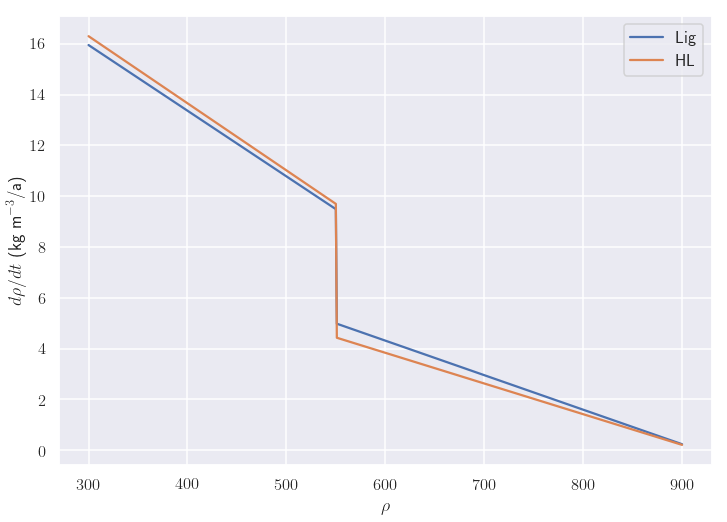

In [48]:
f1,a1= plt.subplots()
a1.plot(rho_range,ll,label='Lig')
a1.plot(rho_range,hh,label='HL')
a1.legend()
a1.set_ylabel(r'$d\rho/dt$ (kg m$^{-3}$/a)')
a1.set_xlabel(r'$\rho$')

We see that indeed HL predicts faster densification in zone 1 but not zone 2. You are looking at how DIP changes when there is strain thinning. If we were looking just in zone 1, it would be clear: the strain thinning densifies the firn a little bit (say from 400 to 410). HL will then predict that that bit of firn will compact more quickly (13.398 kg m$^{-3}$/a) than LIG will (13.110 kg m$^{-3}$/a). 

There is a slight hitch though - LIG predicts faster densification in zone 2, which will compensate for some of what is going on in zone 1 with HL. But, remember that much of the DIP is actually in zone 1. The following plot shows an HL depth-density plot along with the cumulated DIP with depth as a percentage of the total dip, i.e. cumsum(DIP)/total DIP. About 33% of the DIP is in zone 1, even though zone 1 only goes to about 12 m depth, or 12% of the total depth.


Text(0.5, 0, 'Density')

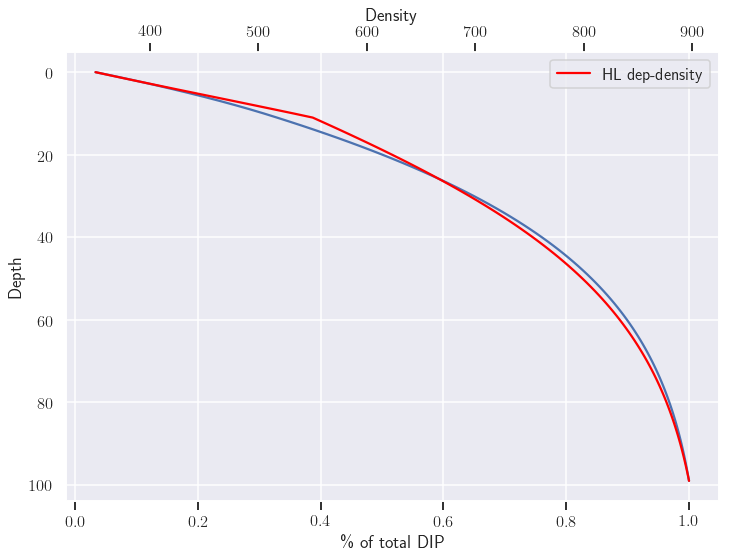

In [49]:
f2,a2 = plt.subplots()
a2.plot(dipP,depth,label='cumulative \% DIP')
a2.invert_yaxis()
a3 = a2.twiny()
a3.plot(hlrho,depth,color = 'red',label='HL dep-density')
a3.grid(False)
a3.legend()
a2.set_ylabel('Depth')
a2.set_xlabel('\% of total DIP')
a3.set_xlabel('Density')